# Dual-sPLS Modeling and Visualization

This notebook demonstrates data loading, inspection, and several modeling techniques using the **dual_spls** package. We show how to compare predictions and performance metrics for different regression models (PLS, LASSO, Ridge, GL, ElasticNet) on full data and on a calibration/validation split. Visualizations are grouped to allow side‐by‐side comparisons, with improved aesthetics including subplots, legends, and grid lines.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import functions from the dual_spls package
from dual_spls.pls import d_spls_pls
from dual_spls.lasso import d_spls_lasso
from dual_spls.calval import d_spls_calval
from dual_spls.ridge import d_spls_ridge
from dual_spls.GL import d_spls_GL, cluster_variables_fixed_groups
from dual_spls.elasticnet import d_spls_elasticnet_mm
from dual_spls.predict import d_spls_predict
from dual_spls.metric import d_spls_metric
from dual_spls.plot import d_spls_plot  # Optional plotting helper

sns.set(style='whitegrid')  # Set a clean seaborn style
plt.rcParams.update({'font.size': 12, 'figure.figsize': (8, 5)})

## Data Loading

We load the various CSV files containing the NIR spectrum data, derivative spectra, and the response variable. Adjust the file paths as required.

In [ ]:
data_dir = "."  
file_X           = os.path.join(data_dir, "D_nir/matrixXNirSpectrumData.csv")
file_X_axis      = os.path.join(data_dir, "D_nir/matrixXNirSpectrumDataAxis.csv")
file_deriv       = os.path.join(data_dir, "D_nir/matrixXNirSpectrumDerivative.csv")
file_deriv_axis  = os.path.join(data_dir, "D_nir/matrixXNirSpectrumDerivativeAxis.csv")
file_y           = os.path.join(data_dir, "D_nir/matrixYNirPropertyDensityNormalized.csv")

try:
    X            = np.loadtxt(file_X, delimiter=',').T
    X_axis       = np.loadtxt(file_X_axis, delimiter=',').T
    X_deriv      = np.loadtxt(file_deriv, delimiter=',').T
    X_deriv_axis = np.loadtxt(file_deriv_axis, delimiter=',').T
    y            = np.loadtxt(file_y, delimiter=',').T
except Exception as e:
    print("Error loading files:", e)

print(f"X: {X.shape}, X_axis: {X_axis.shape}, X_deriv: {X_deriv.shape}, \
X_deriv_axis: {X_deriv_axis.shape}, y: {y.shape}")

X: (208, 2635), X_axis: (2635,), X_deriv: (208, 2594), X_deriv_axis: (2594,), y: (208,)


## Data Inspection and Visualization

We first compute a correlation heatmap of the concatenated data (X and y) and then display the response spectrum. The plots below are presented side by side for quick comparison.

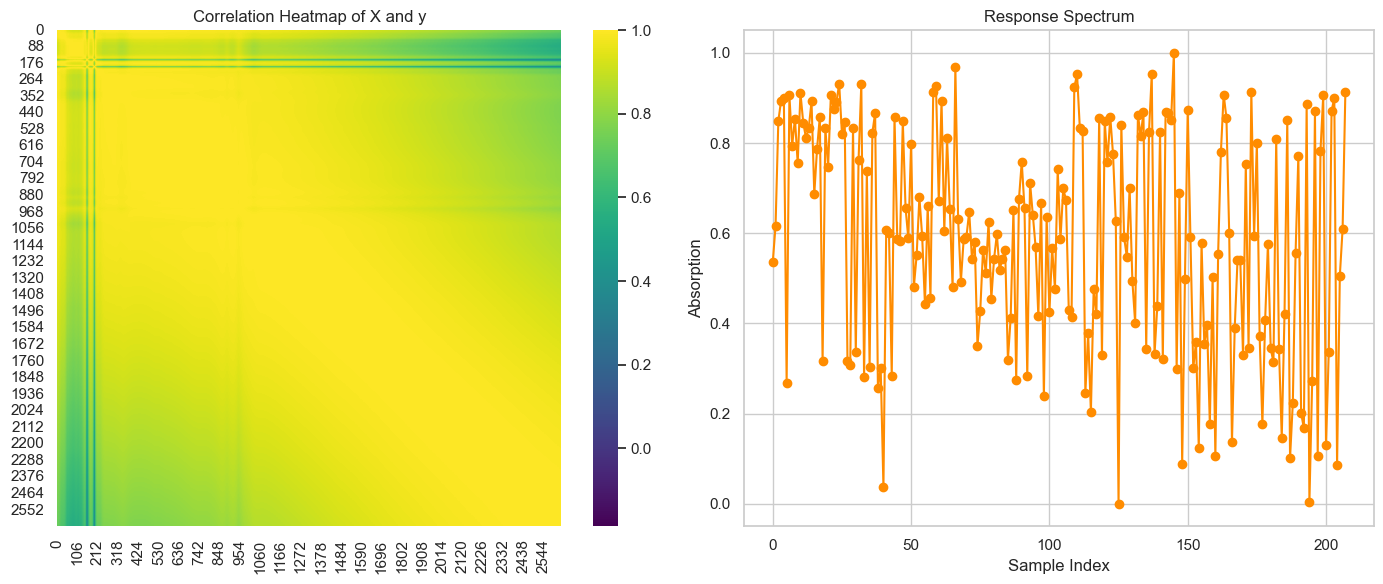

NaNs in y: 0 | NaNs in X: 0


In [3]:
# Combine X and y for correlation analysis
Z = np.concatenate((X, y[:, None]), axis=1)

# Create a figure with two subplots: one for the heatmap and one for the response plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
corr = np.corrcoef(Z.T)
sns.heatmap(corr, ax=axes[0], cmap='viridis')
axes[0].set_title('Correlation Heatmap of X and y')

# Plot for response y
axes[1].plot(y, marker='o', linestyle='-', color='darkorange')
axes[1].set_title('Response Spectrum')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Absorption')

plt.tight_layout()
plt.show()

print("NaNs in y:", np.isnan(y).sum(), "| NaNs in X:", np.isnan(X).sum())

## Calibration / Validation Split

We now split the full data into calibration and validation sets using the provided function.

In [4]:
ind = d_spls_calval(X, pcal=70, y=y, method="pca_euclidean", pc=0.9)
X_cal, X_val = X[ind['indcal'], :], X[ind['indval'], :]
y_cal, y_val = y[ind['indcal']], y[ind['indval']]
print("Calibration y shape:", y_cal.shape)

Calibration y shape: (145,)


## Full Data Modeling: PLS and LASSO

First, we fit PLS and Lasso models on our dataset for 100 components first for arbitrary hyperparametres (ncp and ppnu). 

PLS model type: pls
Intercept: [ 0.45430802  0.6449452   2.92609102  2.29467362  3.59486131  4.30131171
  4.52852854  3.93449909  3.97516609  2.97835904  2.84097238  2.37422249
  1.87897292  2.19505796  2.0037171   1.86069098  1.54298482  0.36577879
 -1.5218289  -2.02461979 -2.28705098 -2.09988992 -2.22999539 -2.97613147
 -3.40018327 -3.49324872 -3.7381015  -4.61847211 -4.50474624 -4.43973396
 -3.06591098 -2.12636724 -2.15275096 -2.31509845 -2.64333671 -2.93577348
 -3.57377172 -3.75498337 -2.90859938 -3.0762433  -3.4047548  -3.71305973
 -3.94460401 -3.04475381 -2.37813372 -2.73711702 -2.90205574 -3.34282463
 -3.57271767 -3.48453343]
Bhat shape: (2635, 50)
LASSO model type: lasso
Intercept: [ 0.45448831  1.20673946  2.84104224  1.94853512  2.53855126  3.27419845
  3.66417673  4.1310086   3.82547099  3.68951074  3.23382587  2.30414686
  2.63475492  2.46833741  2.57010968  2.37107238  2.08771545  1.42326601
  0.63691549 -0.03296781 -0.99032439 -1.26994295 -1.2384356  -1.84171139
 -1.88020

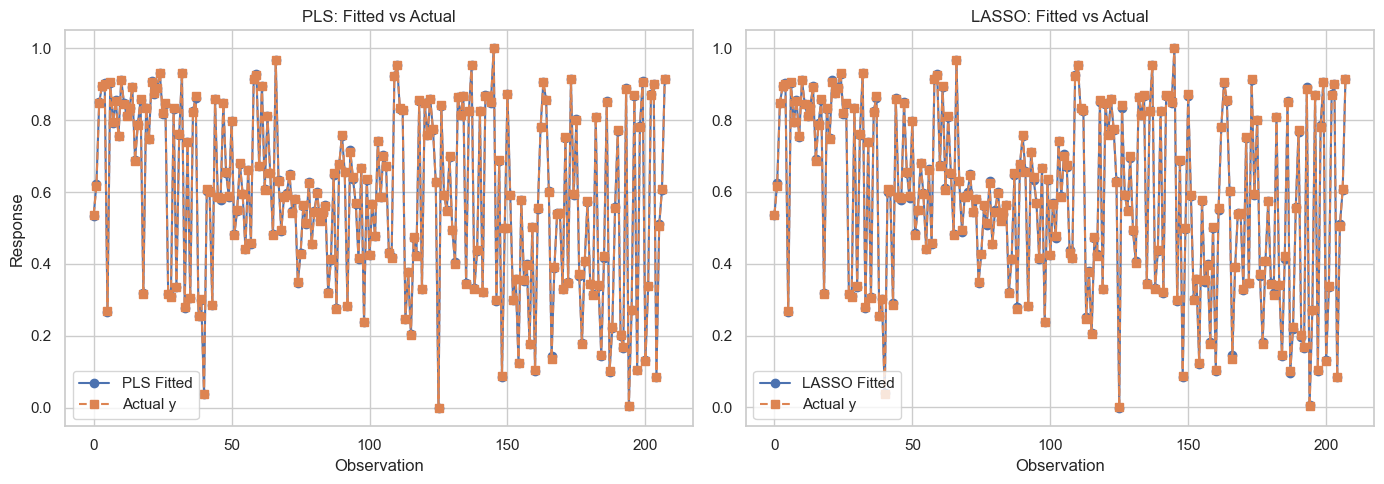

In [5]:
# PLS Model
ncp = 50
ppnu=0.7
model_pls = d_spls_pls(X, y, ncp=ncp, verbose=False)
print("PLS model type:", model_pls.get('type', 'unknown'))
print("Intercept:", model_pls['intercept'])
print("Bhat shape:", model_pls['Bhat'].shape)

# LASSO Model
model_lasso = d_spls_lasso(X, y, ncp=ncp, ppnu=ppnu, verbose=False)
print("LASSO model type:", model_lasso.get('type', 'unknown'))
print("Intercept:", model_lasso['intercept'])
print("Bhat shape:", model_lasso['Bhat'].shape)

# Create subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PLS fitted vs actual
axes[0].plot(model_pls['fitted_values'][:, -1], label='PLS Fitted', marker='o')
axes[0].plot(y, label='Actual y', marker='s', linestyle='--')
axes[0].set_title('PLS: Fitted vs Actual')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# LASSO fitted vs actual
axes[1].plot(model_lasso['fitted_values'].T[-1], label='LASSO Fitted', marker='o')
axes[1].plot(y, label='Actual y', marker='s', linestyle='--')
axes[1].set_title('LASSO: Fitted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

plt.tight_layout()
plt.show()

## Calibration Data Modeling: LASSO

Here we fit a LASSO model on the calibration data. Hyperparameters chosen are minimisors of residuals on validation dataset. The following subplots show:

- **Top:** Fitted values on calibration data vs. the observed response.
- **Middle:** Predictions on the validation set compared to actual validation responses.
- **Bottom:** Performance metrics (MSE and R²) for the model on the validation set.

In [6]:
# Fit LASSO model on calibration data
ncp=50
ppnu=[0.8,0.9,0.95,0.99]
best_rmse=float('inf')
best_np_lasso=0

for ppnu_i in ppnu:
    model_lasso_cal_i = d_spls_lasso(X_cal, y_cal, ncp=ncp, ppnu=ppnu_i, verbose=False)
    idmin=np.argmin(d_spls_metric(model_lasso_cal_i,X_val,y_val)['MSE'])
    min=d_spls_metric(model_lasso_cal_i,X_val,y_val)['MSE'][idmin]
    if min<best_rmse:
        model_lasso_cal=model_lasso_cal_i
        best_np_lasso=idmin
print("Cal LASSO model type:", model_lasso_cal.get('type', 'unknown'))
print("Intercept:", model_lasso_cal['intercept'])
print("Bhat shape:", model_lasso_cal['Bhat'].shape)

Cal LASSO model type: lasso
Intercept: [ 0.44866047  1.49583745  2.86881914  1.72506798  2.42712942  1.0049534
  1.36858238  3.56640781  3.38809668  3.45048137  3.20569026  2.81640635
  3.10046118  3.0423487   3.55500195  3.66493625  3.21783992  2.89838794
  2.83862879  2.82792185  2.94389265  3.02534773  2.63910851  2.20945134
  1.04596437  0.95495394  0.82983319  0.81182712  0.06041278 -0.07283368
 -1.40327073 -2.46383152 -3.08273415 -4.49654822 -5.26058136 -5.67658684
 -6.55146154 -5.92672944 -5.89450237 -4.97241541 -4.43708184 -4.76612014
 -4.54041356 -5.28419541 -5.90184056 -7.217606   -6.6682848  -5.14144821
 -4.41098488 -5.05462235]
Bhat shape: (2635, 50)


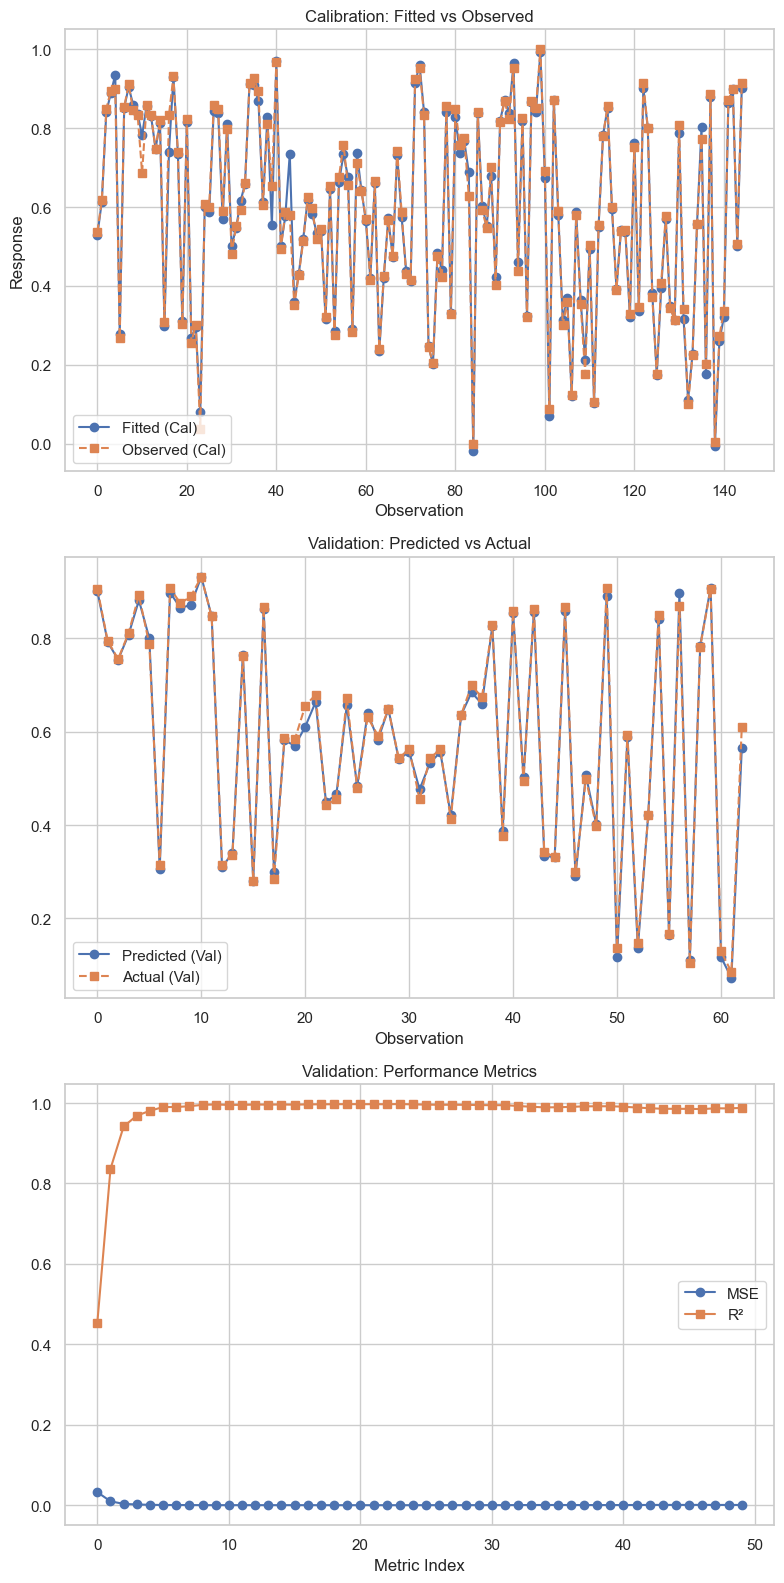

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_lasso_cal['fitted_values'].T[best_np_lasso], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_lasso_cal, X_val).T[best_np_lasso]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_lasso_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibration for pls

In [24]:
# Fit pls model on calibration data
ncp=50
ppnu=[0.8,0.9,0.95,0.99]
model_pls_cal = d_spls_pls(X_cal, y_cal, ncp=ncp,  verbose=False)
idmin=np.argmin(d_spls_metric(model_pls_cal,X_val,y_val)['MSE'])
min=d_spls_metric(model_pls_cal,X_val,y_val)['MSE'][idmin]

best_np_pls=idmin
print("Cal pls model type:", model_pls_cal.get('type', 'unknown'))
print("Intercept:", model_pls_cal['intercept'])
print("Bhat shape:", model_pls_cal['Bhat'].shape)

Cal pls model type: pls
Intercept: [ 0.4471746   0.59445035  2.95616247  2.40731279  3.67988169  4.67433931
  4.400929    3.89628007  3.92894791  3.14897112  2.93789086  2.34371932
  1.83908997  2.22930569  2.11984026  1.67026835  1.02370897 -0.47513421
 -1.82370567 -2.23325933 -2.67435011 -2.71222452 -3.54372665 -3.87090737
 -3.91397164 -4.10891091 -4.55191373 -5.00451275 -4.75528003 -4.18821716
 -3.15658378 -2.41344794 -2.46316562 -3.08116481 -3.83463559 -4.22359682
 -4.77717737 -4.8248277  -3.61914598 -3.82259517 -4.49237633 -3.92344344
 -3.33668957 -3.31900935 -3.20467651 -3.1706698  -3.65907797 -3.36995579
 -3.40414514 -3.39997178]
Bhat shape: (2635, 50)


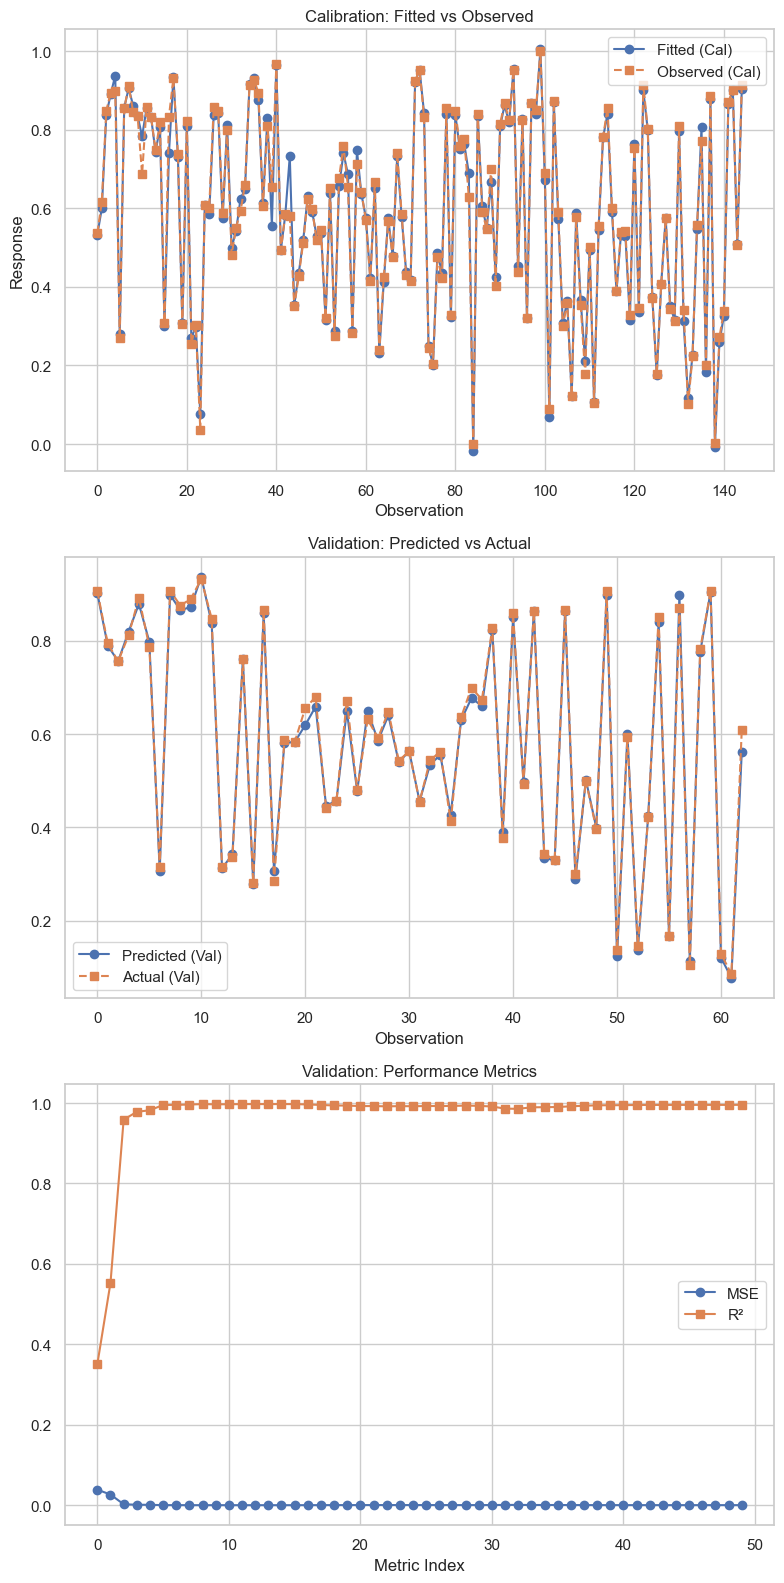

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_pls_cal['fitted_values'].T[best_np_pls], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_pls_cal, X_val).T[best_np_pls]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_pls_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibration Data Modeling: Ridge

Now we fit a Ridge model on the calibration data and compare calibration fitted values and validation predictions.

In [8]:
# Fit ridge model on calibration data
ncp=50
ppnu=[0.8,0.9,0.95,0.99]
best_rmse=float('inf')
best_np_ridge=0

for ppnu_i in ppnu:
    model_ridge_cal_i = d_spls_ridge(X_cal, y_cal, ncp=ncp, ppnu=ppnu_i, verbose=False)
    idmin=np.argmin(d_spls_metric(model_ridge_cal_i,X_val,y_val)['MSE'])
    min=d_spls_metric(model_ridge_cal_i,X_val,y_val)['MSE'][idmin]
    if min<best_rmse:
        model_ridge_cal=model_ridge_cal_i
        best_np_ridge=idmin
print("Cal ridge model type:", model_ridge_cal.get('type', 'unknown'))
print("Intercept:", model_ridge_cal['intercept'])
print("Bhat shape:", model_ridge_cal['Bhat'].shape)

Cal ridge model type: ridge
Intercept: [0.58772568 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203 3.45345203
 3.45345203 3.45345203]
Bhat shape: (2635, 50)


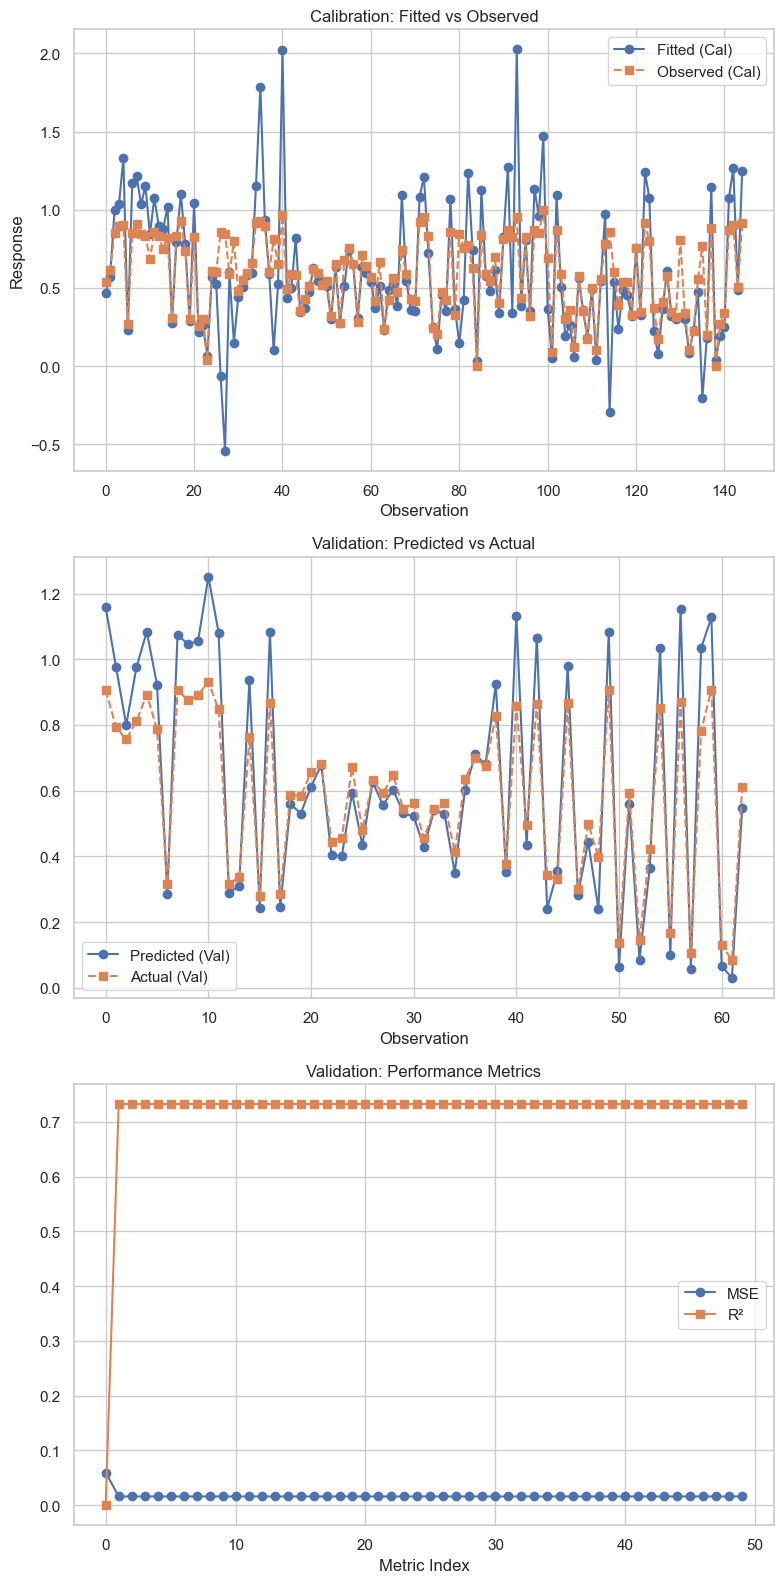

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_ridge_cal['fitted_values'].T[best_np_ridge], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_ridge_cal, X_val).T[best_np_ridge]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_ridge_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

## Calibration Data Modeling: GL Model with Variable Clustering

The GL model groups variables via clustering (using a Ward method) and fits a model on the calibration data. In addition to fitted and predicted comparisons, we plot the regression coefficients and compute the sparsity ratio.

for norm A

In [35]:
# Fit gl model on calibration data
ncp=50 #reduced for time complexity
ppnu=[0.8,0.9,0.95,0.99]
best_rmse=float('inf')
best_np_gl=0
indG = cluster_variables_fixed_groups(X_cal, method='ward', n_groups=5)
norm='A'
for ppnu_i in ppnu:
    model_gl_cal_i = d_spls_GL(X_cal, y_cal,norm=norm, ncp=ncp, ppnu=ppnu_i,indG=indG, verbose=True)
    idmin=np.argmin(d_spls_metric(model_gl_cal_i,X_val,y_val)['MSE'])
    min=d_spls_metric(model_gl_cal_i,X_val,y_val)['MSE'][idmin]
    if min<best_rmse:
        model_gl_cal=model_gl_cal_i
        best_np_gl=idmin
print("Cal gl model type:", model_gl_cal.get('type', 'unknown'))
print("Intercept:", model_gl_cal['intercept'])
print("Bhat shape:", model_gl_cal['Bhat'].shape)

Dual PLS ic = 1 | lambda = [2.79387983 1.45256599 0.85429994 1.85892021 0.84191404] | mu = 20.227590827474707 | nu = [14.61350029  9.94000047  1.0214662   5.89446202  3.18866957] | nbzeros = [314 640 144 625 834]
Dual PLS ic = 2 | lambda = [0.69456281 1.67899816 0.5162576  7.94098558 0.41295914] | mu = 4.373853040073466 | nu = [0.32210603 0.59350866 1.03318371 0.62985514 0.60952675] | nbzeros = [314 640 115 625 834]
Dual PLS ic = 3 | lambda = [1.11935956 2.88505722 0.7932628  0.75808335 0.84305013] | mu = 2.8511117051843398 | nu = [0.25388773 0.6174741  0.35235254 0.78967406 0.7793311 ] | nbzeros = [314 640 115 625 667]
Dual PLS ic = 4 | lambda = [1.32470292 7.52830213 0.42119414 2.42779184 0.19801304] | mu = 0.29596242863842237 | nu = [0.05208295 0.07153601 0.02431868 0.06408009 0.03227842] | nbzeros = [236 640  88 625 667]
Dual PLS ic = 5 | lambda = [ 0.25235233  0.59064412  1.28816274 19.66598137  0.52955772] | mu = 0.0634244370293002 | nu = [0.00173728 0.00627713 0.02750608 0.00952

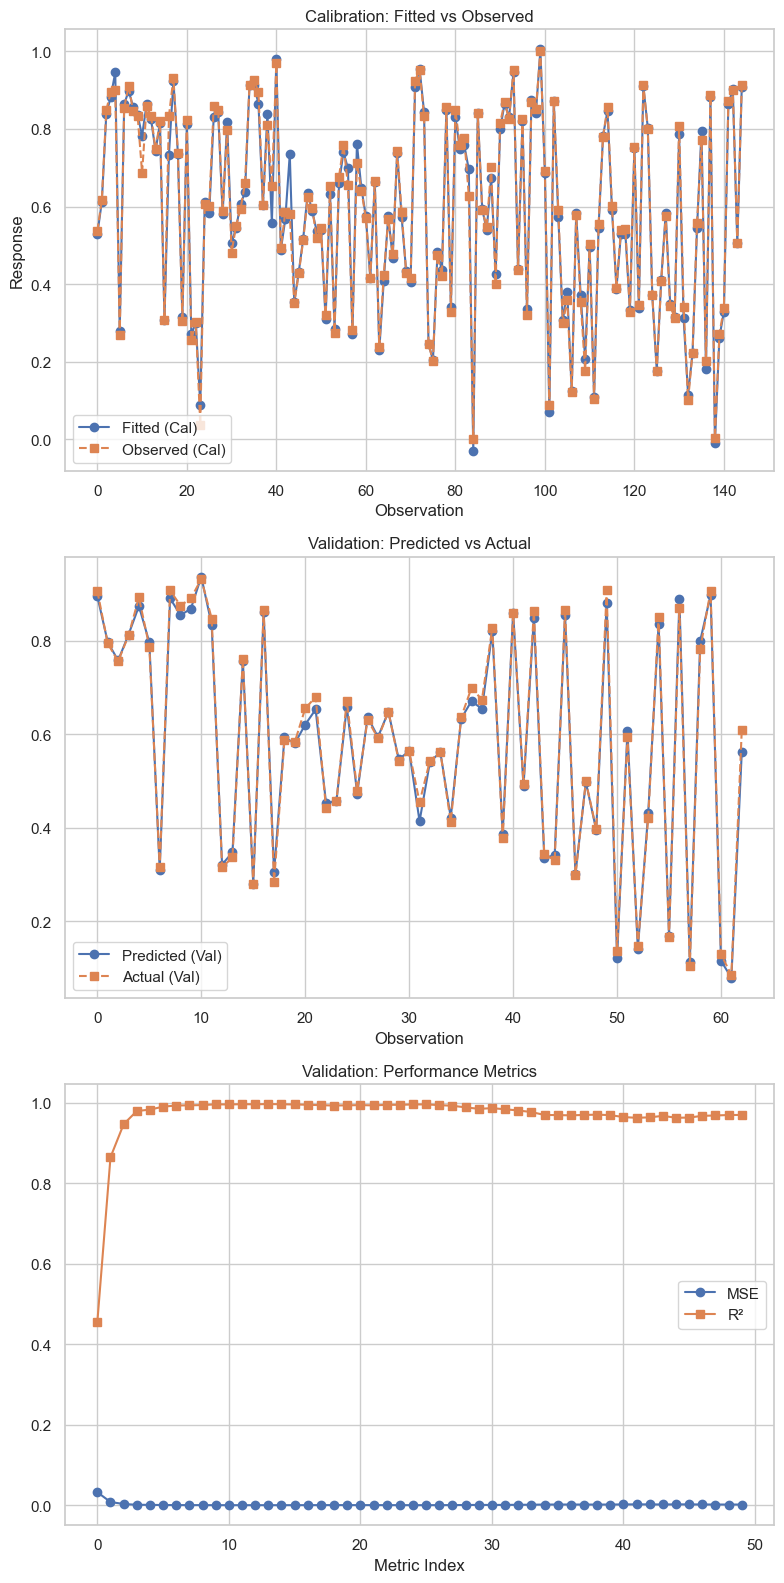

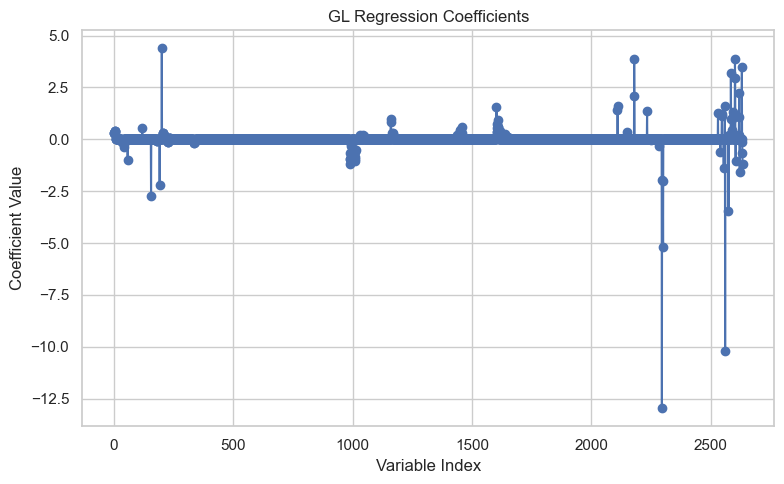

GL sparsity ratio: 0.0633776091081594


In [36]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_gl_cal['fitted_values'].T[best_np_gl], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_gl_cal, X_val).T[best_np_gl]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_gl_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

# Plot GL regression coefficients and compute sparsity
B = model_gl_cal['Bhat']
sprsty = B.T[best_np_gl]
ratio_sprs = np.count_nonzero(sprsty) / len(sprsty)

plt.figure(figsize=(8, 5))
plt.plot(sprsty, marker='o', linestyle='-')
plt.title('GL Regression Coefficients')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()
print("GL sparsity ratio:", ratio_sprs)

for norm B:

In [37]:
# Fit glb model on calibration data
ncp=50 #we set n_groups to 5
ppnu=[[0.8 for _ in range(5)],[0.9 for _ in range(5)],[0.95 for _ in range(5)],[0.99 for _ in range(5)]]
best_rmse=float('inf')
best_np_glb=0
indG = cluster_variables_fixed_groups(X_cal, method='ward', n_groups=5)
norm='B'
for ppnu_i in ppnu:
    model_glb_cal_i = d_spls_GL(X_cal, y_cal,norm=norm, ncp=ncp, ppnu=ppnu_i,indG=indG, verbose=True)
    idmin=np.argmin(d_spls_metric(model_glb_cal_i,X_val,y_val)['MSE'])
    min=d_spls_metric(model_glb_cal_i,X_val,y_val)['MSE'][idmin]
    if min<best_rmse:
        model_glb_cal=model_glb_cal_i
        best_np_glb=idmin
print("Cal glb model type:", model_glb_cal.get('type', 'unknown'))
print("Intercept:", model_glb_cal['intercept'])
print("Bhat shape:", model_glb_cal['Bhat'].shape)

Dual PLS ic=1 lambda=[1.461242   0.99392657 0.10213907 0.58940263 0.31884339], mu=10.000739279442634, nu=[14.61350029  9.94000047  1.0214662   5.89446202  3.18866957], nbzeros=[314. 512. 115. 500. 667.]
Dual PLS ic=2 lambda=[0.33071739 0.13673697 0.42275693 0.22260759 0.25408441], mu=2.957061194189667, nu=[0.97795155 0.4043396  1.25011812 0.65826427 0.75134314], nbzeros=[312. 384.  86. 375. 599.]
Dual PLS ic=3 lambda=[0.07898159 0.04530593 0.08187682 0.1100553  0.12778105], mu=2.813573514834618, nu=[0.2222205  0.12747157 0.23036645 0.30964866 0.35952139], nbzeros=[305. 366.  86. 254. 432.]
Dual PLS ic=4 lambda=[0.08965772 0.1092216  0.25484238 0.06845915 0.11293847], mu=0.12475782596589281, nu=[0.0111855  0.01362625 0.03179358 0.00854081 0.01408996], nbzeros=[301. 279.  64. 254. 352.]
Dual PLS ic=5 lambda=[0.11109622 0.08242933 0.23037401 0.10031494 0.09150307], mu=0.08031607354570437, nu=[0.00892281 0.0066204  0.01850274 0.0080569  0.00734917], nbzeros=[276. 279.  48. 223. 345.]
Dual 

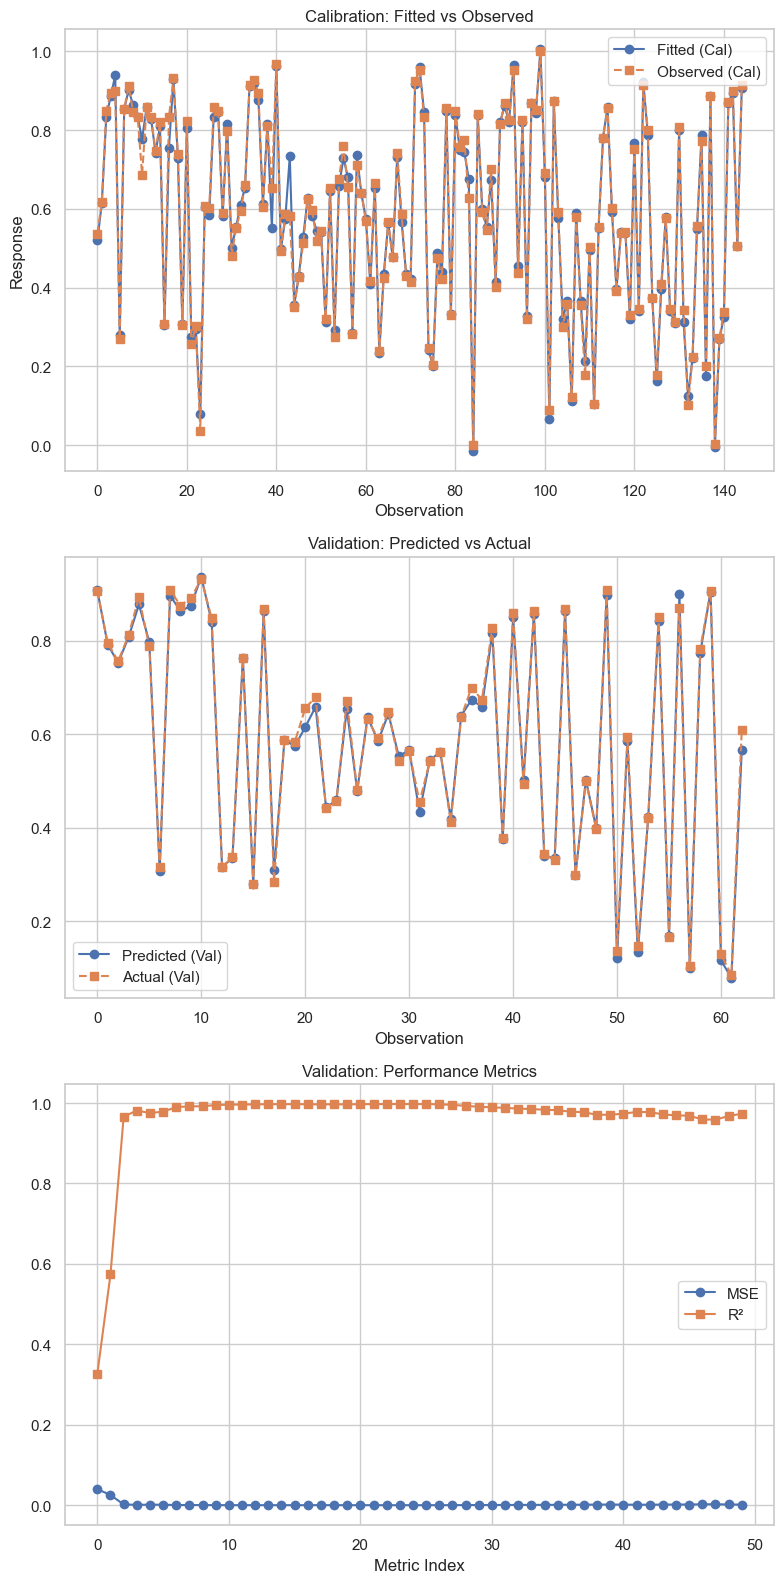

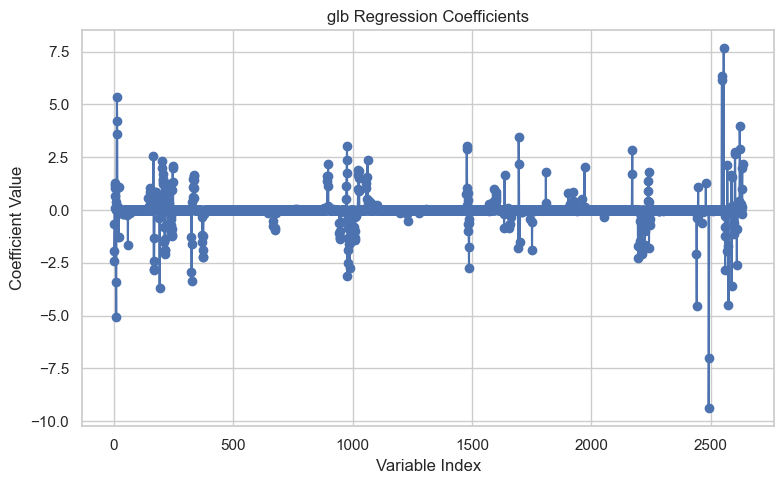

glb sparsity ratio: 0.15673624288425048


In [38]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_glb_cal['fitted_values'].T[best_np_glb], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_glb_cal, X_val).T[best_np_glb]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_glb_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

# Plot glb regression coefficients and compute sparsity
B = model_glb_cal['Bhat']
sprsty = B.T[best_np_glb]
ratio_sprs = np.count_nonzero(sprsty) / len(sprsty)

plt.figure(figsize=(8, 5))
plt.plot(sprsty, marker='o', linestyle='-')
plt.title('glb Regression Coefficients')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()
print("glb sparsity ratio:", ratio_sprs)

## Calibration Data Modeling: Elastic Net

Finally, we fit an Elastic Net model (using dual_spls elasticnet) on the calibration data. We then compare fitted versus observed values and show the performance metrics as well as the sparsity of the solution.

In [12]:
# Fit en model on calibration data
ncp=50 #reduced for time complexity
ppnu=[0.8,0.9,0.95,0.99]
best_rmse=float('inf')
best_np_en=0
for ppnu_i in ppnu:
    model_en_cal_i = d_spls_elasticnet_mm(X_cal, y_cal, ncp=ncp,  verbose=True)
    idmin=np.argmin(d_spls_metric(model_en_cal_i,X_val,y_val)['MSE'])
    min=d_spls_metric(model_en_cal_i,X_val,y_val)['MSE'][idmin]
    if min<best_rmse:
        model_en_cal=model_en_cal_i
        best_np_en=idmin
print("Cal en model type:", model_en_cal.get('type', 'unknown'))
print("Intercept:", model_en_cal['intercept'])
print("Bhat shape:", model_en_cal['Bhat'].shape)

[MM Dual-sPLS EN] Component 1, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 2, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 3, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 4, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 5, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 6, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 7, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 8, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 9, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 10, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 11, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 12, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 13, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 14, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 15, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 16, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 17, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 18, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 19, Dual norm = 0.0000
[MM Dual-sPLS EN] Component 20, Dual nor

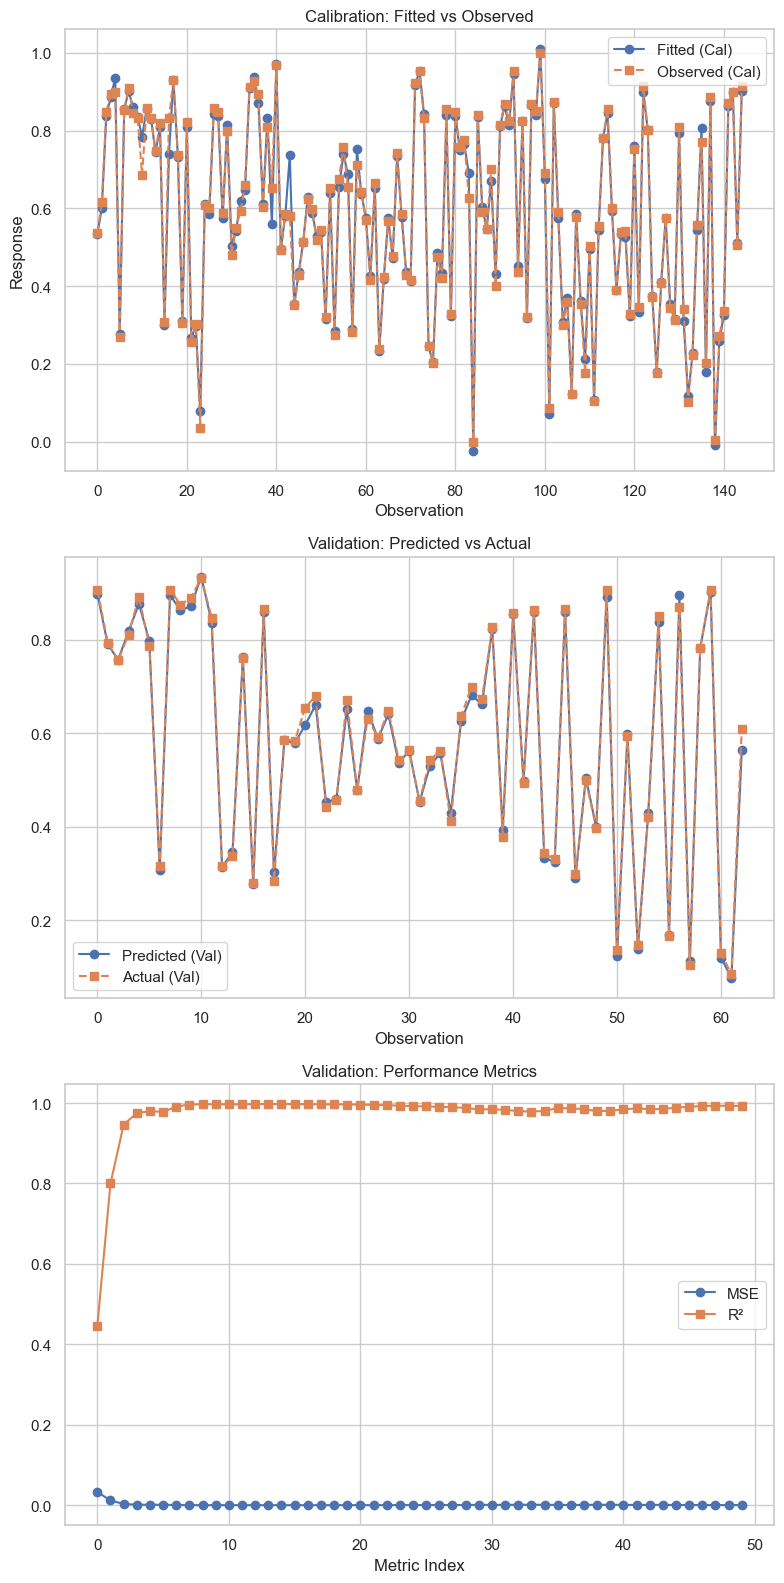

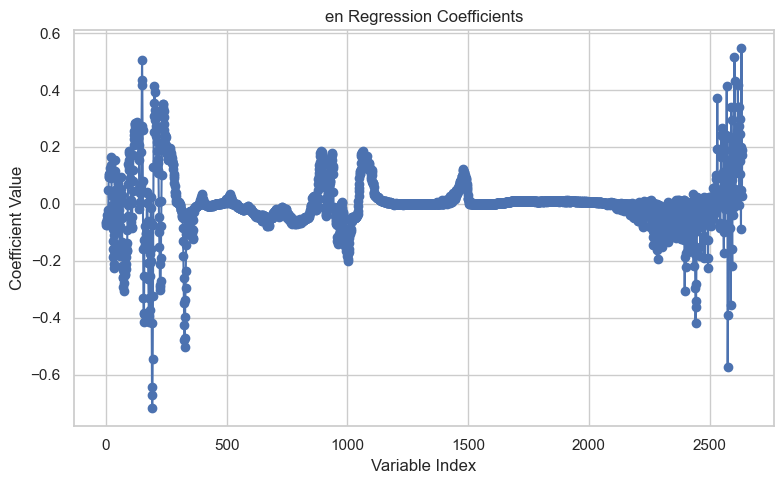

en sparsity ratio: 0.9715370018975332


In [13]:
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Top: Fitted vs observed on calibration
axes[0].plot(model_en_cal['fitted_values'].T[best_np_en], label='Fitted (Cal)', marker='o')
axes[0].plot(y_cal, label='Observed (Cal)', marker='s', linestyle='--')
axes[0].set_title('Calibration: Fitted vs Observed')
axes[0].set_xlabel('Observation')
axes[0].set_ylabel('Response')
axes[0].legend()

# Middle: Predicted on validation
y_new = d_spls_predict(model_en_cal, X_val).T[best_np_en]
axes[1].plot(y_new, label='Predicted (Val)', marker='o')
axes[1].plot(y_val, label='Actual (Val)', marker='s', linestyle='--')
axes[1].set_title('Validation: Predicted vs Actual')
axes[1].set_xlabel('Observation')
axes[1].legend()

# Bottom: Performance Metrics
metrics = d_spls_metric(model_en_cal, X_val, y_val)
axes[2].plot(metrics['MSE'], label='MSE', marker='o')
axes[2].plot(metrics['R2'], label='R²', marker='s')
axes[2].set_title('Validation: Performance Metrics')
axes[2].set_xlabel('Metric Index')
axes[2].legend()

plt.tight_layout()
plt.show()

# Plot en regression coefficients and compute sparsity
B = model_en_cal['Bhat']
sprsty = B.T[best_np_en]
ratio_sprs = np.count_nonzero(sprsty) / len(sprsty)

plt.figure(figsize=(8, 5))
plt.plot(sprsty, marker='o', linestyle='-')
plt.title('en Regression Coefficients')
plt.xlabel('Variable Index')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()
print("en sparsity ratio:", ratio_sprs)

## Comparison

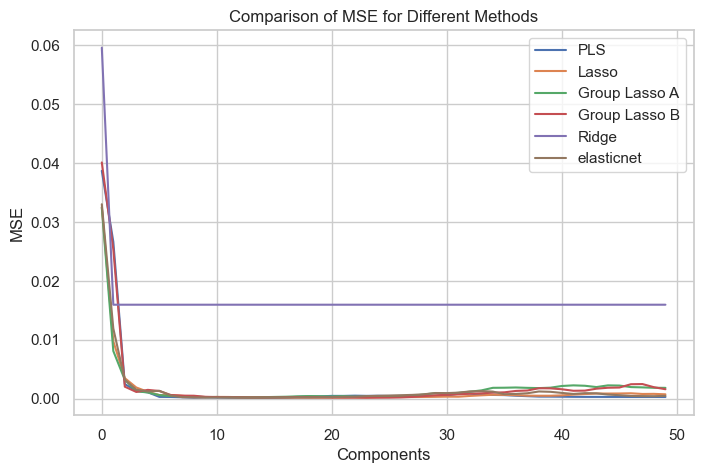

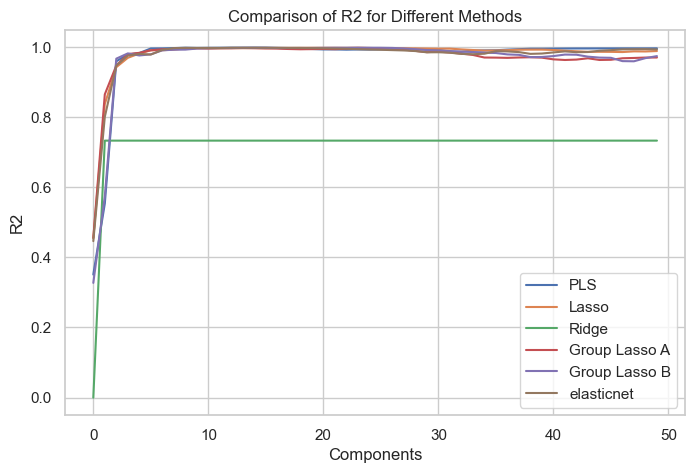

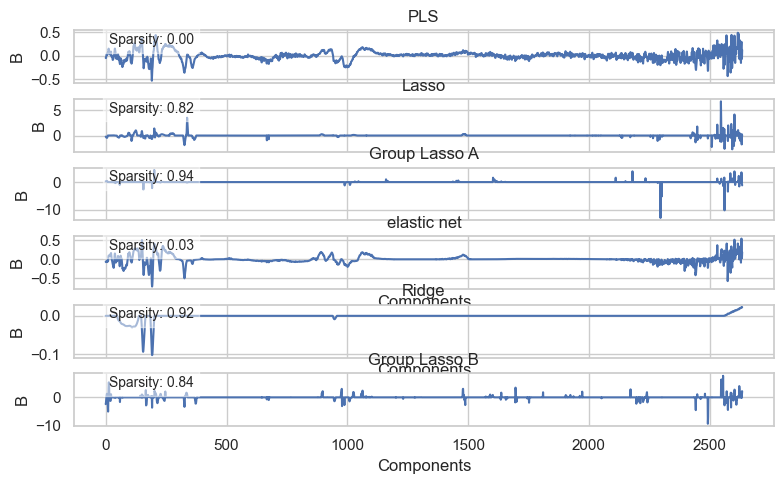

In [39]:
yfitted_pls = model_pls_cal['fitted_values'][:,best_np_pls]
yfitted_lasso = model_lasso_cal['fitted_values'][:,best_np_lasso]
yfitted_ridge = model_ridge_cal['fitted_values'][:,best_np_ridge]
yfitted_GL = model_gl_cal['fitted_values'][:,best_np_gl]
yfitted_GLB = model_glb_cal['fitted_values'][:,best_np_glb]
yfitted_elasticnet = model_en_cal['fitted_values'][:,best_np_en]

metrics_pls=d_spls_metric(model_pls_cal,X_val,y_val)
metrics_lasso=d_spls_metric(model_lasso_cal,X_val,y_val)
metrics_ridge=d_spls_metric(model_ridge_cal,X_val,y_val)
metrics_GL=d_spls_metric(model_gl_cal,X_val,y_val)
metrics_GLB=d_spls_metric(model_glb_cal,X_val,y_val)
metrics_elasticnet=d_spls_metric(model_en_cal,X_val,y_val)

plt.plot(metrics_pls['MSE'], label='PLS')
plt.plot(metrics_lasso['MSE'], label='Lasso')
plt.plot(metrics_GL['MSE'], label='Group Lasso A')
plt.plot(metrics_GLB['MSE'], label='Group Lasso B')
plt.plot(metrics_ridge['MSE'], label='Ridge')
plt.plot(metrics_elasticnet['MSE'], label='elasticnet')
plt.xlabel('Components')
plt.ylabel('MSE')
plt.title('Comparison of MSE for Different Methods')
plt.legend()
plt.show()

plt.plot(metrics_pls['R2'], label='PLS')
plt.plot(metrics_lasso['R2'], label='Lasso')
plt.plot(metrics_ridge['R2'], label='Ridge')
plt.plot(metrics_GL['R2'], label='Group Lasso A')
plt.plot(metrics_GLB['R2'], label='Group Lasso B')
plt.plot(metrics_elasticnet['R2'], label='elasticnet')
plt.xlabel('Components')
plt.ylabel('R2')
plt.title('Comparison of R2 for Different Methods')
plt.legend()
plt.show()

B_pls = model_pls_cal['Bhat'].T[best_np_pls]
ratio_pls = 1-np.count_nonzero(B_pls)/len(B_pls)

B_lasso = model_lasso_cal['Bhat'].T[best_np_lasso]
ratio_lasso = 1-np.count_nonzero(B_lasso)/len(B_lasso)

B_ridge = model_ridge_cal['Bhat'].T[best_np_ridge]
ratio_ridge = 1-np.count_nonzero(B_ridge)/len(B_ridge)

B_GL = model_gl_cal['Bhat'].T[best_np_gl]
ratio_GL = 1-np.count_nonzero(B_GL)/len(B_GL)

B_GLB = model_glb_cal['Bhat'].T[best_np_glb]
ratio_GLB = 1-np.count_nonzero(B_GLB)/len(B_GLB)

B_elasticnet = model_en_cal['Bhat'].T[best_np_en]
ratio_elasticnet = 1-np.count_nonzero(B_elasticnet)/len(B_elasticnet)


fig, axes = plt.subplots(6, 1, figsize=(8, 5), sharex=True)

# Plot pour PLS
axes[0].plot(B_pls)
axes[0].set_title('PLS')
axes[0].text(0.05, 0.95, f'Sparsity: {ratio_pls:.2f}', transform=axes[0].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[0].set_ylabel('B')

# Plot pour Lasso
axes[1].plot(B_lasso)
axes[1].set_title('Lasso')
axes[1].text(0.05, 0.95, f'Sparsity: {ratio_lasso:.2f}', transform=axes[1].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[1].set_ylabel('B')

# Plot pour Group Lasso
axes[2].plot(B_GL)
axes[2].set_title('Group Lasso A')
axes[2].text(0.05, 0.95, f'Sparsity: {ratio_GL:.2f}', transform=axes[2].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[2].set_ylabel('B')

# Plot pour elastic net
axes[3].plot(B_elasticnet)
axes[3].set_title('elastic net')
axes[3].text(0.05, 0.95, f'Sparsity: {ratio_elasticnet:.2f}', transform=axes[3].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[3].set_ylabel('B')
axes[3].set_xlabel('Components')


# Plot pour elastic net
axes[4].plot(B_ridge)
axes[4].set_title('Ridge')
axes[4].text(0.05, 0.95, f'Sparsity: {ratio_ridge:.2f}', transform=axes[4].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[4].set_ylabel('B')
axes[4].set_xlabel('Components')

# Plot pour glb net
axes[5].plot(B_GLB)
axes[5].set_title('Group Lasso B')
axes[5].text(0.05, 0.95, f'Sparsity: {ratio_GLB:.2f}', transform=axes[5].transAxes,
fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
axes[5].set_ylabel('B')
axes[5].set_xlabel('Components')

# Enlève l'espace entre les subplots pour coller les graphes comme sur ton image
plt.tight_layout()
plt.subplots_adjust(hspace=0.3) # Ajuste selon ce que tu préfères

plt.show()
